# CM50268 :: Gaussian Processes (practice example)


## Tasks

- Implement a numpy function that evaluates the squared exponential kernel using for loops and use it to check that the tensorflow function provided is correct. 

- Get the GP regression code running on a toy example with a Gaussian likelihood

- Now run the code on traffic count data (the training outputs are integers) and observe what happens. Add a brief text comment highlighting what has gone wrong and why. 

- Implement a periodic kernel to replace the squared exponential kernel and run the regression model with the new kernel. Does the situation improve slightly? 


### If you installed the latest TensorFlow 2.0, do the following 2 lines when import:
import tensorflow.compat.v1 as tf 

tf.disable_eager_execution()

#### TensorFlow dtype
Due to interations between the CPU and GPU, TensorFlow is quite strict about the difference between single and double precision floating point numbers (`tf.float32` and `tf.float64`) respectively. To be safe, when declaring constants and variables in TensorFlow I always specify the `dtype` parameter by using defining `dtype` and `dtype_convert` at the top of the file. This allows, for example:
```python
t_vector_of_ones = tf.ones(shape=[5], dtype=dtype)
t_correct_precision = dtype_convert(t_not_correct_precision)
```
If you get tensorflow errors about `tf.float32` and `tf.float64` you probably have a constant declared using the wrong `dtype` somewhere in the computational graph.

#### Inverting the covariance matrix
Covariance matrices should be symmetric and positive definite - this means that they can be inverted using the Cholesky decomposition $K = L L^{\mathtt{T}}$ where $L$ is a square, lower triangular matrix. There is a TensorFlow operation `t_L_matrix = tf.cholesky(t_K_matrix)` that returns the matrix $L$. 

Once you have the decomposed matrix, it is efficient to evaluation the matrix inversion $A = K^{-1} B$ using the special solve operation `t_A_matrix = tf.cholesky_solve(t_L_matrix, t_B_matrix)`. 

If you need to perform the operation $A = L^{-1} B$ there is also a special operation `t_A_matrix = tf.matrix_triangular_solve(t_L_matrix, t_B_matrix)`.

Because the cholesky decomposition requires a positive definite matrix, we often add a small "jitter" diagonal matrix to try to improve the nummerical stability (in case the eigenvalues of the kernel become close to zero). For example we would perform the following:
```python
jitter = 1.0e-8
t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype)
```
where `tf.shape()[0]` is returning the size of the kernel matrix to build a diagonal matrix identity matrix using `tf.eye()` (and we note that we specify the `dtype` of the matrix).


In [1]:
# Import statements..
import warnings
import time
warnings.filterwarnings('ignore')
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import math

import pandas as pd
dtype = tf.float64
dtype_convert = tf.to_double
tf.compat.v1.disable_eager_execution()
np.random.seed(0)

## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation). It is good practice to check your tensorflow code as you write it using simple (but often inefficient) numpy code where we are less likely to introduce errors.

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keepdims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keepdims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

###  Task 1: Implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly. 


# <font color=Red>  Solution <font> 

In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
        
    K = np.array([signal_variance * np.exp((-1*np.linalg.norm(X[i]-X[j])**2)/(2*lengthscale**2)) for i in range(X.shape[0]) for j in range(X.shape[0])]).reshape(X.shape[0],X.shape[0])
    
    return K

# An alternative solution below:

# def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
#     X_square = (X-X.T)**2
#     l_inv = 1.0 /(lengthscale**2)
#     ele = l_inv * X_square
#     K = signal_variance * np.exp(-0.5*ele)
#     # Add code using for loops to generate K(X, X)
    
#     return K


# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)

tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance = t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('My numpy checking code K = \n', numpy_K)
    
    print('shape consistency is:',numpy_K.shape==t_K.shape)

TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
My numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
shape consistency is: True


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood (as per the lecture notes). Look through to see how the function works and correlate the code with the mathematical expressions for the marginal log likelihood and the predictive posterior code. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale     = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq  = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean, 'r-')
    plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
    plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
    plt.grid(True)
    return pred_mean, pred_var
    
    

###  Task 1a: Run the GP model on the following toy dataset to ensure everything is working.

Instructions for updating:
Use `tf.cast` instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.265875491851364
  opt iter   200: objective = 6.282378000976848
  opt iter   400: objective = 6.282377976574965
  opt iter   600: objective = 6.282377976574885
  opt iter   800: objective = 6.282377976574926
  opt iter  1000: objective = 6.282377976574976
  opt iter  1200: objective = 6.2823782013929
  opt iter  1400: objective = 6.28237797657496
  opt iter  1600: objective = 6.282377978273626
  opt iter  1800: objective = 6.2823779767379975
Final iter  1999: objective = 6.282377976574949

After Optimisation:
signal_variance = 0.95869
lengthscale = 0.590214
sigma_noise_squared = 0.0145719



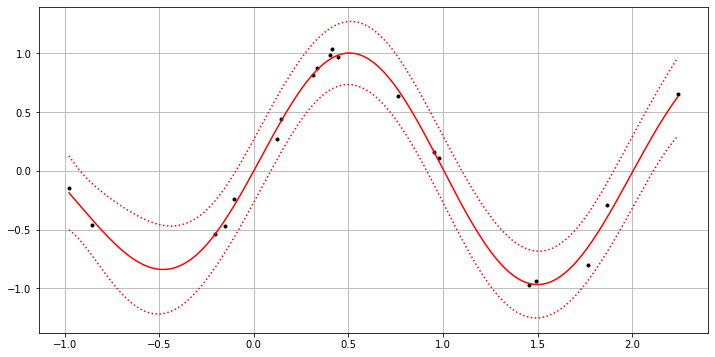

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is taken from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


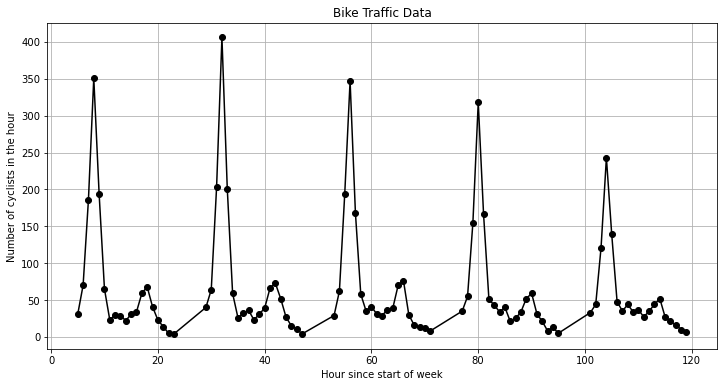

In [6]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.values.flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

###  Task 2: Run the GP code with a squared exponential kernel on the bike count data. 

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.72843773945
  opt iter   200: objective = 1974.7006453601134
  opt iter   400: objective = 1002.7616672497594
  opt iter   600: objective = 769.091789456638
  opt iter   800: objective = 687.3504092835026
  opt iter  1000: objective = 653.8017301622654
  opt iter  1200: objective = 638.9149470729808
  opt iter  1400: objective = 632.0909944106786
  opt iter  1600: objective = 628.9576378086268
  opt iter  1800: objective = 627.5484481436596
Final iter  1999: objective = 626.9384260486808

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



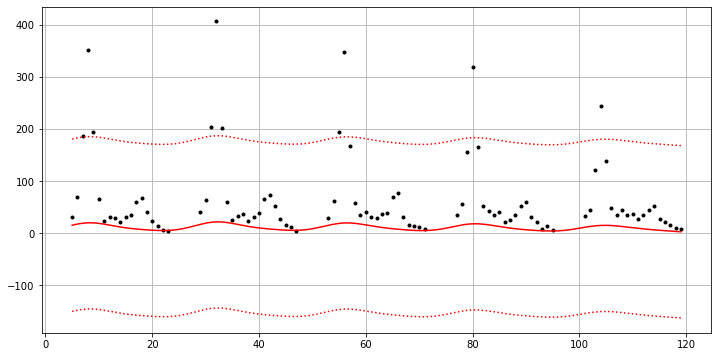

In [7]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Switch to using periodic kernel

###  Task 3: Implement the periodic kernel and copy and paste the GP code from above, modifying it to use your new periodic kernel and verify the results by running the code with pre-defined settings.

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

# <font color=Red> Solutions are in the function `numpy_squared_exp_kernel` and the modified `create_periodic_gp` function. <font> 

In [8]:
def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    
    dist_x1x2 = tf.reduce_sum(t_X1 * t_X1, axis=1, keepdims=True) + \
                tf.transpose(tf.reduce_sum(t_X2 * t_X2, axis=1, keepdims=True)) - \
                2*tf.matmul(t_X1, t_X2, transpose_b=True)
    
    sin_term  = (tf.math.sin(np.pi*(dist_x1x2**0.5)/t_period))**2

    return t_signal_variance * tf.exp(- 2 * t_gamma * sin_term)

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X    = tf.constant(input_data, dtype=dtype)
    t_Y    = tf.constant(output_data, dtype=dtype)

    t_N    = tf.shape(t_Y)[0]
    t_D    = tf.shape(t_Y)[1]
    t_Q    = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance   = create_positive_variable(initial_signal_variance)
    t_sigma_noise_sq    = create_positive_variable(initial_sigma_noise_sq)
    t_period            = create_positive_variable(initial_period)
    t_gamma             = create_positive_variable(initial_gamma)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'period': t_period,
                           'gamma': t_gamma,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1        = t_X1, 
                                  t_X2     = t_X2,
                                  t_gamma  = t_gamma,
                                  t_period = t_period,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

### Task 3a *Run the code below after writing the functions above..*

Before Optimisation:
signal_variance = 1.0
period = 24.0
gamma = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 136405.73566419655
  opt iter   200: objective = 1252.7107134038674
  opt iter   400: objective = 857.3609077712333
  opt iter   600: objective = 697.4311969996462
  opt iter   800: objective = 616.8084327531105
  opt iter  1000: objective = 572.1304593276392
  opt iter  1200: objective = 545.8368878939825
  opt iter  1400: objective = 529.732301294309
  opt iter  1600: objective = 519.6127975313601
  opt iter  1800: objective = 513.1599295135545
Final iter  1999: objective = 509.03647296590725

After Optimisation:
signal_variance = 3367.54
period = 24.0078
gamma = 13.7982
sigma_noise_squared = 166.431



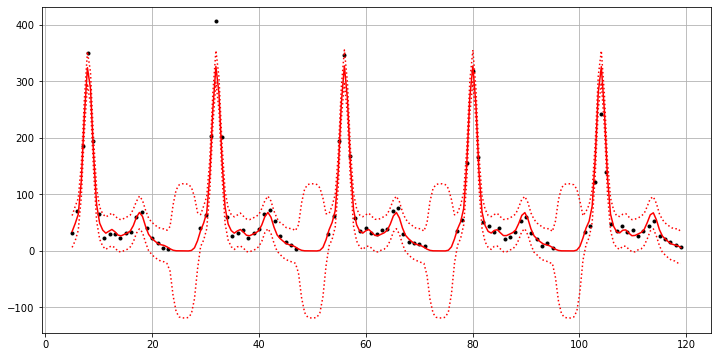

In [9]:
def plot_pgp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    plt.figure(figsize=[12,6])
#     plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
    plt.grid(True)
    plt.show()
    return pred_mean, pred_var

tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp_periodic = create_periodic_gp(input_data   = input_data, 
                        output_data  = output_data, 
                        initial_signal_variance = 1.0,
                        initial_gamma  = 1.0,
                        initial_period = 24.0,
                        initial_sigma_noise_sq = 1.0)



# session = tf.Session()
with tf.Session() as session:
    feed_dict = {}

    t_objective = gp_periodic.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)

    session.run(tf.global_variables_initializer())

    print('Before Optimisation:')
    print_hyperparameters(gp_periodic, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))

    print('After Optimisation:')
    print_hyperparameters(gp_periodic, session)

    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)

    periodic_mean, periodic_var = plot_gp_predictions(gp_periodic, session, input_values)

## GP model example with sklearn

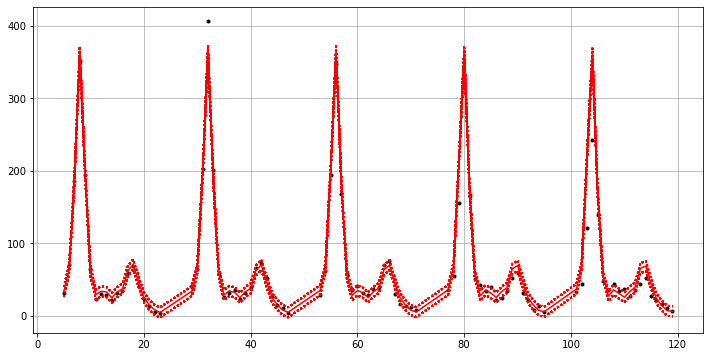

In [10]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel
X= bike_times
y = bike_counts
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=21, periodicity_bounds=(15, 30))

kernel_1  = k0 + k1 
gp1 = gaussian_process.GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp1.fit(X[:50], y[:50]) # 50 samples as training set

pred_mean, pred_var = gp1.predict(X, return_std=True) # all samples as test+training here, just for visualization
plt.figure(figsize=[12,6])
plt.plot(X, y, 'k.')
plt.plot(X, pred_mean, 'r-')
plt.plot(X, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
plt.plot(X, pred_mean - 2.0 *  np.sqrt(pred_var), 'r:')
plt.grid(True)
plt.show()